In [1]:
import feature_engineering as Fe
import pandas as pd
import os
import random
import math
from tqdm import tqdm
import numpy as np
import time

In [2]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
DATA_PATH = '/opt/ml/input/data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True) 

In [3]:
# dtype = {
#     'userID': 'int16',
#     'answerCode': 'int8',
#     'KnowledgeTag': 'int16'
# }   

# train = pd.read_csv("/opt/ml/input/data/cv_train_data.csv", dtype=dtype, parse_dates=['Timestamp'])
# valid = pd.read_csv("/opt/ml/input/data/cv_valid_data.csv", dtype=dtype, parse_dates=['Timestamp'])

In [4]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
test_csv_file_path = '/opt/ml/input/data/test_data.csv'
test = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])
test = test.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [5]:
# 문제 번호
df['problem_number'] = df['assessmentItemID'].apply(lambda x : int(x[-3:]))
test['problem_number'] = test['assessmentItemID'].apply(lambda x : int(x[-3:]))

In [6]:
correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
correct_t.columns = ["test_mean", 'test_sum']

correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
correct_k.columns = ["tag_mean", 'tag_sum']

correct_a = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
correct_a.columns = ["ass_mean", 'ass_sum']

correct_p = df.groupby(['problem_number'])['answerCode'].agg(['mean', 'sum'])
correct_p.columns = ["prb_mean", 'prb_sum']

In [7]:
prac = df.copy()

# FE

In [8]:
prac = Fe.IK_question_acc(prac)
prac = Fe.IK_KnowledgeTag_acc(prac)
test = Fe.IK_question_acc(test)
test = Fe.IK_KnowledgeTag_acc(test)

In [9]:
# #time elapsed 
# diff = prac.loc[:, ['userID','Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
# diff = diff.fillna(pd.Timedelta(seconds=0))
# diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
# prac['elapsed'] = diff
# prac['elapsed'] = prac['elapsed'].apply(lambda x : x if x <650 and x >=0 else 0)

In [9]:
#solved_question , 유저별 푼 문제 수
prac["solved_question"] = prac.groupby(["userID"]).cumcount()
test["solved_question"] = test.groupby(["userID"]).cumcount()

In [10]:
#time elapsed 
def change_elapsed(data):
    return data["elapsed"] if not data["is_elapsed_more_600"] else data["userID_testId_elapsed_mean"]
    
def change_log_elapsed(data):
    return data["log_elapsed"] if not data["is_elapsed_more_10"] else data["userID_testId_log_elapsed_mean"]

def get_elapsed(df):
    diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1).fillna(pd.Timedelta(seconds=0))
    elapsed = diff['Timestamp'].apply(lambda x: x.total_seconds())
    elapsed_log = diff['Timestamp'].apply(lambda x: np.log1p(x.total_seconds()))
    
    df['elapsed'] = elapsed
    df['log_elapsed'] = elapsed_log
    
    ### 특정 기준치를 벗어나면 해당 user의 해당 test지에 대한 평균 elapsed time으로 교체
    df["is_elapsed_more_600"] = df["elapsed"].apply(lambda x : True if x > 600 else False)
    df["is_elapsed_more_10"] = df["log_elapsed"].apply(lambda x : True if x > 10 else False)
    
    group_userID_testId = df[~df["is_elapsed_more_600"]].groupby(["userID", "testId"])["elapsed"].agg(["mean"])
    group_userID_testId = group_userID_testId.reset_index()
    group_userID_testId.columns = ["userID", "testId", "userID_testId_elapsed_mean"]

    group_userID_testId_log = df[~df["is_elapsed_more_10"]].groupby(["userID", "testId"])["log_elapsed"].agg(["mean"])
    group_userID_testId_log = group_userID_testId_log.reset_index()
    group_userID_testId_log.columns = ["userID", "testId", "userID_testId_log_elapsed_mean"]

    df = pd.merge(df, group_userID_testId, on=["userID", "testId"], how="left")
    df = pd.merge(df, group_userID_testId_log, on=["userID", "testId"], how="left")

    df["elapsed"] = df.apply(change_elapsed, axis=1)
    df["log_elapsed"] = df.apply(change_log_elapsed, axis=1)
    
    df = df.drop(['is_elapsed_more_600', 'is_elapsed_more_10', 'userID_testId_elapsed_mean', 'userID_testId_log_elapsed_mean'], axis=1)
    df = df.fillna(0.0)
    
    return df

In [11]:
prac = get_elapsed(prac)
test = get_elapsed(test)

In [12]:
def is_probably_easy(row):
    delta = row.delta
    delta_thres = 1 # hour
    
    is_prev_ord = row.is_previous_ordered
    is_prev_dec = row.is_previous_decreasing
    is_prev_ord_shift = row.is_prev_ord_shift
    is_prev_dec_shift = row.is_prev_dec_shift
    
    case = (is_prev_ord_shift, is_prev_dec_shift, is_prev_ord, is_prev_dec)
    
    probably_easy_l = [
        (np.nan, np.nan, -1, -1),
        (-1, -1, 1, 0),
        (1, 0, 1, 0),
        (1, 0, 0, 0),
    ]
    
    if pd.isnull(delta) or delta > pd.Timedelta(hours=1):
        return -1
    elif case in probably_easy_l:
        return 1
    else:
        return 0

def is_previous_decreasing(row):
    q_num = row.problem_number
    q_num_prev = row.q_num_prev
    delta = row.delta
    delta_thres = 1 # hour
    
    if pd.isnull(delta) or delta > pd.Timedelta(hours=1):
        return -1
    elif q_num < q_num_prev:
        return 1
    else:
        return 0

def add_last_problem(df):
    new = []
    pre = df['testId'][0]
    for idx in df['testId']:
        if pre != idx :
            new[-1]=-1
            pre = idx
        new.append(0)
    df['last_problem'] = new
    return df

def is_previous_ordered(row):
    q_num = row.problem_number
    q_num_prev = row.q_num_prev
    delta = row.delta
    delta_thres = 1 # hour
    
    if pd.isnull(delta) or delta > pd.Timedelta(hours=1):
        return -1
    elif q_num == q_num_prev + 1:
        return 1
    else:
        return 0

In [13]:
def feature_engineering(df):
    print('-'*20, 'Feature Engineering Start', '-'*20)
    start_time = time.time()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    df = add_last_problem(df)
    # elo 추가
    # df = ELO_function(df)
    
    df['hour'] = df['Timestamp'].dt.hour
    df['dow'] = df['Timestamp'].dt.dayofweek
    
    # 푸는 시간
    # diff = df.loc[:, ['userID','Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    # diff = diff.fillna(pd.Timedelta(seconds=0))
    # diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    # df['elapsed'] = diff
    # df['elapsed'] = df['elapsed'].apply(lambda x : x if x <650 and x >=0 else 0)
    
    df['grade']=df['testId'].apply(lambda x : int(x[1:4])//10)
    df['mid'] = df['testId'].apply(lambda x : int(x[-3:]))
    df['problem_number'] = df['assessmentItemID'].apply(lambda x : int(x[-3:]))
    
#     stu_test_groupby = df.groupby(['userID', 'testId'])
#     df.loc[:, "delta"] = stu_test_groupby['Timestamp'].diff()
#     df['q_num_prev'] = df.problem_number.shift()
#     df['is_previous_ordered'] =  df.apply(lambda row: is_previous_ordered(row), axis=1)
#     df['is_previous_decreasing'] = df.apply(lambda row: is_previous_decreasing(row), axis=1)
#     df['is_prev_ord_shift'] = df.is_previous_ordered.shift()
#     df['is_prev_dec_shift'] = df.is_previous_decreasing.shift()
#     df['is_probably_easy'] = df.apply(lambda row: is_probably_easy(row), axis=1)
#     df.drop(labels=['delta', 'q_num_prev', 'is_previous_ordered',
#                     'is_previous_decreasing', 'is_prev_ord_shift', 'is_prev_dec_shift'], axis=1, inplace=True)
    
    correct_h = df.groupby(['hour'])['answerCode'].agg(['mean', 'sum'])
    correct_h.columns = ["hour_mean", 'hour_sum']
    correct_d = df.groupby(['dow'])['answerCode'].agg(['mean', 'sum'])
    correct_d.columns = ["dow_mean", 'dow_sum'] 
    
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, correct_a, on=['assessmentItemID'], how="left")
    df = pd.merge(df, correct_p, on=['problem_number'], how="left")
    df = pd.merge(df, correct_h, on=['hour'], how="left")
    df = pd.merge(df, correct_d, on=['dow'], how="left")

    o_df = df[df['answerCode']==1]
    x_df = df[df['answerCode']==0]
    
    elp_k = df.groupby(['KnowledgeTag'])['elapsed'].agg('mean').reset_index()
    elp_k.columns = ['KnowledgeTag',"tag_elp"]
    elp_k_o = o_df.groupby(['KnowledgeTag'])['elapsed'].agg('mean').reset_index()
    elp_k_o.columns = ['KnowledgeTag', "tag_elp_o"]
    elp_k_x = x_df.groupby(['KnowledgeTag'])['elapsed'].agg('mean').reset_index()
    elp_k_x.columns = ['KnowledgeTag', "tag_elp_x"]
    
    df = pd.merge(df, elp_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, elp_k_o, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, elp_k_x, on=['KnowledgeTag'], how="left")

    ass_k = df.groupby(['assessmentItemID'])['elapsed'].agg('mean').reset_index()
    ass_k.columns = ['assessmentItemID',"ass_elp"]
    ass_k_o = o_df.groupby(['assessmentItemID'])['elapsed'].agg('mean').reset_index()
    ass_k_o.columns = ['assessmentItemID',"ass_elp_o"]
    ass_k_x = x_df.groupby(['assessmentItemID'])['elapsed'].agg('mean').reset_index()
    ass_k_x.columns = ['assessmentItemID',"ass_elp_x"]

    df = pd.merge(df, ass_k, on=['assessmentItemID'], how="left")
    df = pd.merge(df, ass_k_o, on=['assessmentItemID'], how="left")
    df = pd.merge(df, ass_k_x, on=['assessmentItemID'], how="left")

    prb_k = df.groupby(['problem_number'])['elapsed'].agg('mean').reset_index()
    prb_k.columns = ['problem_number',"prb_elp"]
    prb_k_o = o_df.groupby(['problem_number'])['elapsed'].agg('mean').reset_index()
    prb_k_o.columns = ['problem_number',"prb_elp_o"]
    prb_k_x = x_df.groupby(['problem_number'])['elapsed'].agg('mean').reset_index()
    prb_k_x.columns = ['problem_number',"prb_elp_x"]

    df = pd.merge(df, prb_k, on=['problem_number'], how="left")
    df = pd.merge(df, prb_k_o, on=['problem_number'], how="left")
    df = pd.merge(df, prb_k_x, on=['problem_number'], how="left")
    
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = (df['user_correct_answer']/df['user_total_answer']).fillna(0)
    df['Grade_o'] = df.groupby(['userID','grade'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df['GradeCount'] = df.groupby(['userID','grade']).cumcount()
    df['GradeAcc'] = (df['Grade_o']/df['GradeCount']).fillna(0)
    df['GradeElp'] = df.groupby(['userID','grade'])['elapsed'].transform(lambda x: x.cumsum()).fillna(0)
    df['GradeMElp'] = df['GradeElp']/[v if v != 0 else 1 for v in df['GradeCount'].values]
    
    f = lambda x : len(set(x))
    test = df.groupby(['testId']).agg({
        'problem_number':'max',
        'KnowledgeTag':f
    })
    test.reset_index(inplace=True)

    test.columns = ['testId','problem_count',"tag_count"]
    
    df = pd.merge(df,test,on='testId',how='left')
    
    gdf = df[['userID','testId','problem_number','grade','Timestamp']].sort_values(by=['userID','grade','Timestamp'])
    gdf['buserID'] = gdf['userID'] != gdf['userID'].shift(1)
    gdf['bgrade'] = gdf['grade'] != gdf['grade'].shift(1)
    gdf['first'] = gdf[['buserID','bgrade']].any(axis=1).apply(lambda x : 1- int(x))
    gdf['RepeatedTime'] = gdf['Timestamp'].diff().fillna(pd.Timedelta(seconds=0)) 
    gdf['RepeatedTime'] = gdf['RepeatedTime'].apply(lambda x: x.total_seconds()) * gdf['first']
    df['RepeatedTime'] = gdf['RepeatedTime'].apply(lambda x : math.log(x+1))
    
    df['prior_KnowledgeTag_frequency'] = df.groupby(['userID','KnowledgeTag']).cumcount()
    
    df['problem_position'] = df['problem_number'] / df["problem_count"]
    df['solve_order'] = df.groupby(['userID','testId']).cumcount()
    df['solve_order'] = df['solve_order'] - df['problem_count']*(df['solve_order'] > df['problem_count']).apply(int) + 1
    df['retest'] = (df['solve_order'] > df['problem_count']).apply(int)
    T = df['solve_order'] != df['problem_number']
    TT = T.shift(1)
    TT[0] = False
    df['solved_disorder'] = (TT.apply(lambda x : not x) & T).apply(int)
    
    df['testId'] = df['testId'].apply(lambda x : int(x[1:4]+x[-3]))
    
    print('-'*20, 'Feature Engineering End', '-'*20)
    print(f"Feature Engineering에 걸린 시간 : {time.time() - start_time}s")
    return df

In [14]:
prac = feature_engineering(prac)
prac.head()

-------------------- Feature Engineering Start --------------------
-------------------- Feature Engineering End --------------------
Feature Engineering에 걸린 시간 : 63.08352541923523s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number,IK_question_acc,IK_KnowledgeTag_acc,solved_question,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,0,A060001001,600,1,2020-03-24 00:17:11,7224,1,0.982063,0.955022,0,...,3.0,3.000000,7,2,0.000000,0,0.142857,1,0,0
1,0,A060001002,600,1,2020-03-24 00:17:14,7225,2,0.964126,0.913187,1,...,11.0,11.000000,7,2,1.386294,0,0.285714,2,0,0
2,0,A060001003,600,1,2020-03-24 00:17:22,7225,3,0.910314,0.913187,2,...,18.0,9.000000,7,2,2.197225,1,0.428571,3,0,0
3,0,A060001004,600,1,2020-03-24 00:17:29,7225,4,0.968610,0.913187,3,...,25.0,8.333333,7,2,2.079442,2,0.571429,4,0,0
4,0,A060001005,600,1,2020-03-24 00:17:36,7225,5,0.941704,0.913187,4,...,36.0,9.000000,7,2,2.079442,3,0.714286,5,0,0


In [15]:
test = feature_engineering(test)
test.head()

-------------------- Feature Engineering Start --------------------
-------------------- Feature Engineering End --------------------
Feature Engineering에 걸린 시간 : 5.917088270187378s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number,IK_question_acc,IK_KnowledgeTag_acc,solved_question,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,3,A050023001,500,1,2020-01-09 10:56:31,2626,1,0.75000,0.587097,0,...,26.0,26.00,7,4,0.000000,0,0.142857,1,0,0
1,3,A050023002,500,1,2020-01-09 10:56:57,2626,2,0.56250,0.587097,1,...,120.0,120.00,7,4,3.295837,1,0.285714,2,0,0
2,3,A050023003,500,0,2020-01-09 10:58:31,2625,3,0.34375,0.588517,2,...,125.0,62.50,7,4,4.553877,0,0.428571,3,0,0
3,3,A050023004,500,0,2020-01-09 10:58:36,2625,4,0.50000,0.588517,3,...,132.0,44.00,7,4,1.791759,1,0.571429,4,0,0
4,3,A050023006,500,0,2020-01-09 10:58:43,2623,6,0.28125,0.581986,4,...,135.0,33.75,7,4,2.079442,0,0.857143,5,0,1


In [16]:
# 얘도 이미 나눠져있어서 필요없음
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    valid = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    valid = valid[valid['userID'] != valid['userID'].shift(-1)]
    return train, valid

In [17]:
train, valid = custom_train_test_split(prac)


In [18]:
train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)

In [19]:
train.to_csv('/opt/ml/input/data/FE_dataset/train_after.csv', index = False)
valid.to_csv('/opt/ml/input/data/FE_dataset/valid_after.csv', index = False)
test.to_csv('/opt/ml/input/data/FE_dataset/test_after.csv', index = False)

# 카테고리 피처 라벨링

In [20]:
# 유저별 분리

# 사용할 Feature 설정
FEATS = ['testId', 
       'KnowledgeTag', 'problem_number', 'IK_question_acc',
       'IK_KnowledgeTag_acc', 'solved_question', 'elapsed', 'log_elapsed',
       'last_problem', 'hour', 'dow', 'grade', 'mid', 'test_mean', 'test_sum',
       'tag_mean', 'tag_sum', 'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum',
       'hour_mean', 'hour_sum', 'dow_mean', 'dow_sum', 'tag_elp', 'tag_elp_o',
       'tag_elp_x', 'ass_elp', 'ass_elp_o', 'ass_elp_x', 'prb_elp',
       'prb_elp_o', 'prb_elp_x', 'user_correct_answer', 'user_total_answer',
       'user_acc', 'Grade_o', 'GradeCount', 'GradeAcc', 'GradeElp',
       'GradeMElp', 'problem_count', 'tag_count', 'RepeatedTime',
       'prior_KnowledgeTag_frequency', 'problem_position', 'solve_order',
       'retest', 'solved_disorder']



In [21]:
train = pd.read_csv("/opt/ml/input/data/FE_dataset/train_after.csv")
valid = pd.read_csv("/opt/ml/input/data/FE_dataset/valid_after.csv")
test = pd.read_csv('/opt/ml/input/data/FE_dataset/test_after.csv')

In [22]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_feats = ['grade']
label_feats = ['problem_number','hour','dow','solved_disorder','KnowledgeTag','testId','retest']
        
# 'problem_number','grade', 'testId','KnowledgeTag','problem_count','type_count','solved_disorder'

for c in ordinal_feats :
    X = train[c].values.reshape(-1,1)
    enc = OrdinalEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X
    
for c in label_feats :
    X = train[c].values.reshape(-1,1)
    enc = LabelEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_valid = valid['answerCode']
valid = valid.drop(['answerCode'], axis=1)

In [24]:
# LEAVE LAST INTERACTION ONLY
test = test[test['userID'] != test['userID'].shift(-1)]
# DROP ANSWERCODE
y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [25]:
# rows 744인거 확인하기
test

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,problem_number,IK_question_acc,IK_KnowledgeTag_acc,solved_question,elapsed,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
1035,3,A050133008,9,2020-10-26 13:13:57,469,7,0.470588,0.542662,1035,0.0,...,54746.505828,63.584792,8,2,3.850148,11,1.0,8,0,0
1706,4,A070146008,13,2020-12-27 02:47:54,781,7,0.153846,0.565693,670,0.0,...,26800.857143,63.060840,8,2,3.178054,3,1.0,8,0,0
3023,13,A070111008,13,2020-12-27 04:35:09,820,7,0.285714,0.446753,1316,0.0,...,10255.154221,20.971686,8,3,2.197225,6,1.0,8,0,0
4283,17,A090064006,16,2020-10-30 05:48:37,309,5,0.250000,0.514286,1259,0.0,...,22602.600000,54.860680,6,1,4.330733,5,1.0,6,0,0
4670,26,A060135007,11,2020-10-23 11:44:18,183,6,0.321429,0.602767,386,0.0,...,13724.305952,41.090736,7,1,2.890372,6,1.0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,7,2020-09-08 02:05:20,883,4,0.358974,0.654902,23,0.0,...,24.500000,2.722222,5,2,1.098612,2,1.0,5,0,0
260067,7404,A030111005,5,2020-10-13 09:49:18,589,4,0.861111,0.834661,14,0.0,...,219.000000,54.750000,5,1,4.682131,4,1.0,5,0,0
260082,7416,A050193004,9,2020-10-04 02:44:41,865,3,0.760000,0.792517,14,0.0,...,47.000000,15.666667,4,1,3.218876,3,1.0,4,0,0
260097,7417,A050193004,9,2020-09-06 13:09:15,865,3,0.760000,0.792517,14,0.0,...,63.000000,21.000000,4,1,3.091042,3,1.0,4,0,0


In [27]:
import lightgbm as lgb

lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_valid = lgb.Dataset(valid[FEATS], y_valid)
lgb_test = lgb.Dataset(test[FEATS], y_test)

# Training

In [28]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [30]:
'''
    original
'''
model = lgb.train(
                    {'objective': 'binary','metric':'auc', 'boosting' : 'dart', 'learning_rate':0.05},
#                     {'objective': 'binary','metric':'auc','boosting':'dart',
#                      'learning_rate':0.05,'max_depth':15,'feature_fraction':0.8},
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=100,
                    num_boost_round=8000,
                    early_stopping_rounds=200
                )

# model = lgb.train(
#     {'objective': 'binary'}, 
#     lgb_train,
#     valid_sets=[lgb_train, lgb_test],
#     verbose_eval=100,
#     num_boost_round=500,
#     early_stopping_rounds=100
# )

model.save_model('/opt/ml/output/LGBM_4.txt')

preds = model.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')
#VALID AUC : 0.8352326817779808 ACC : 0.757847533632287 - LGBM2 8000round 두번째 낸거
#VALID AUC : 0.8290278343651559 ACC : 0.7548579970104634 - LGBM3 2000round 처음낸거


[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7425
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
[100]	training's auc: 0.846872	valid_1's auc: 0.79204
[200]	training's auc: 0.849826	valid_1's auc: 0.799692
[300]	training's auc: 0.852213	valid_1's auc: 0.806374
[400]	training's auc: 0.853708	valid_1's auc: 0.809777
[500]	training's auc: 0.855117	valid_1's auc: 0.812673
[600]	training's auc: 0.855651	valid_1's auc: 0.814235
[700]	training's auc: 0.856278	valid_1's auc: 0.8159
[800]	training's auc: 0.856769	valid_1's auc: 0.816653

In [33]:
## 불러올때 이렇게 불러와야된다 ~!!!
model = lgb.Booster(model_file='/opt/ml/output/LGBM_4.txt')

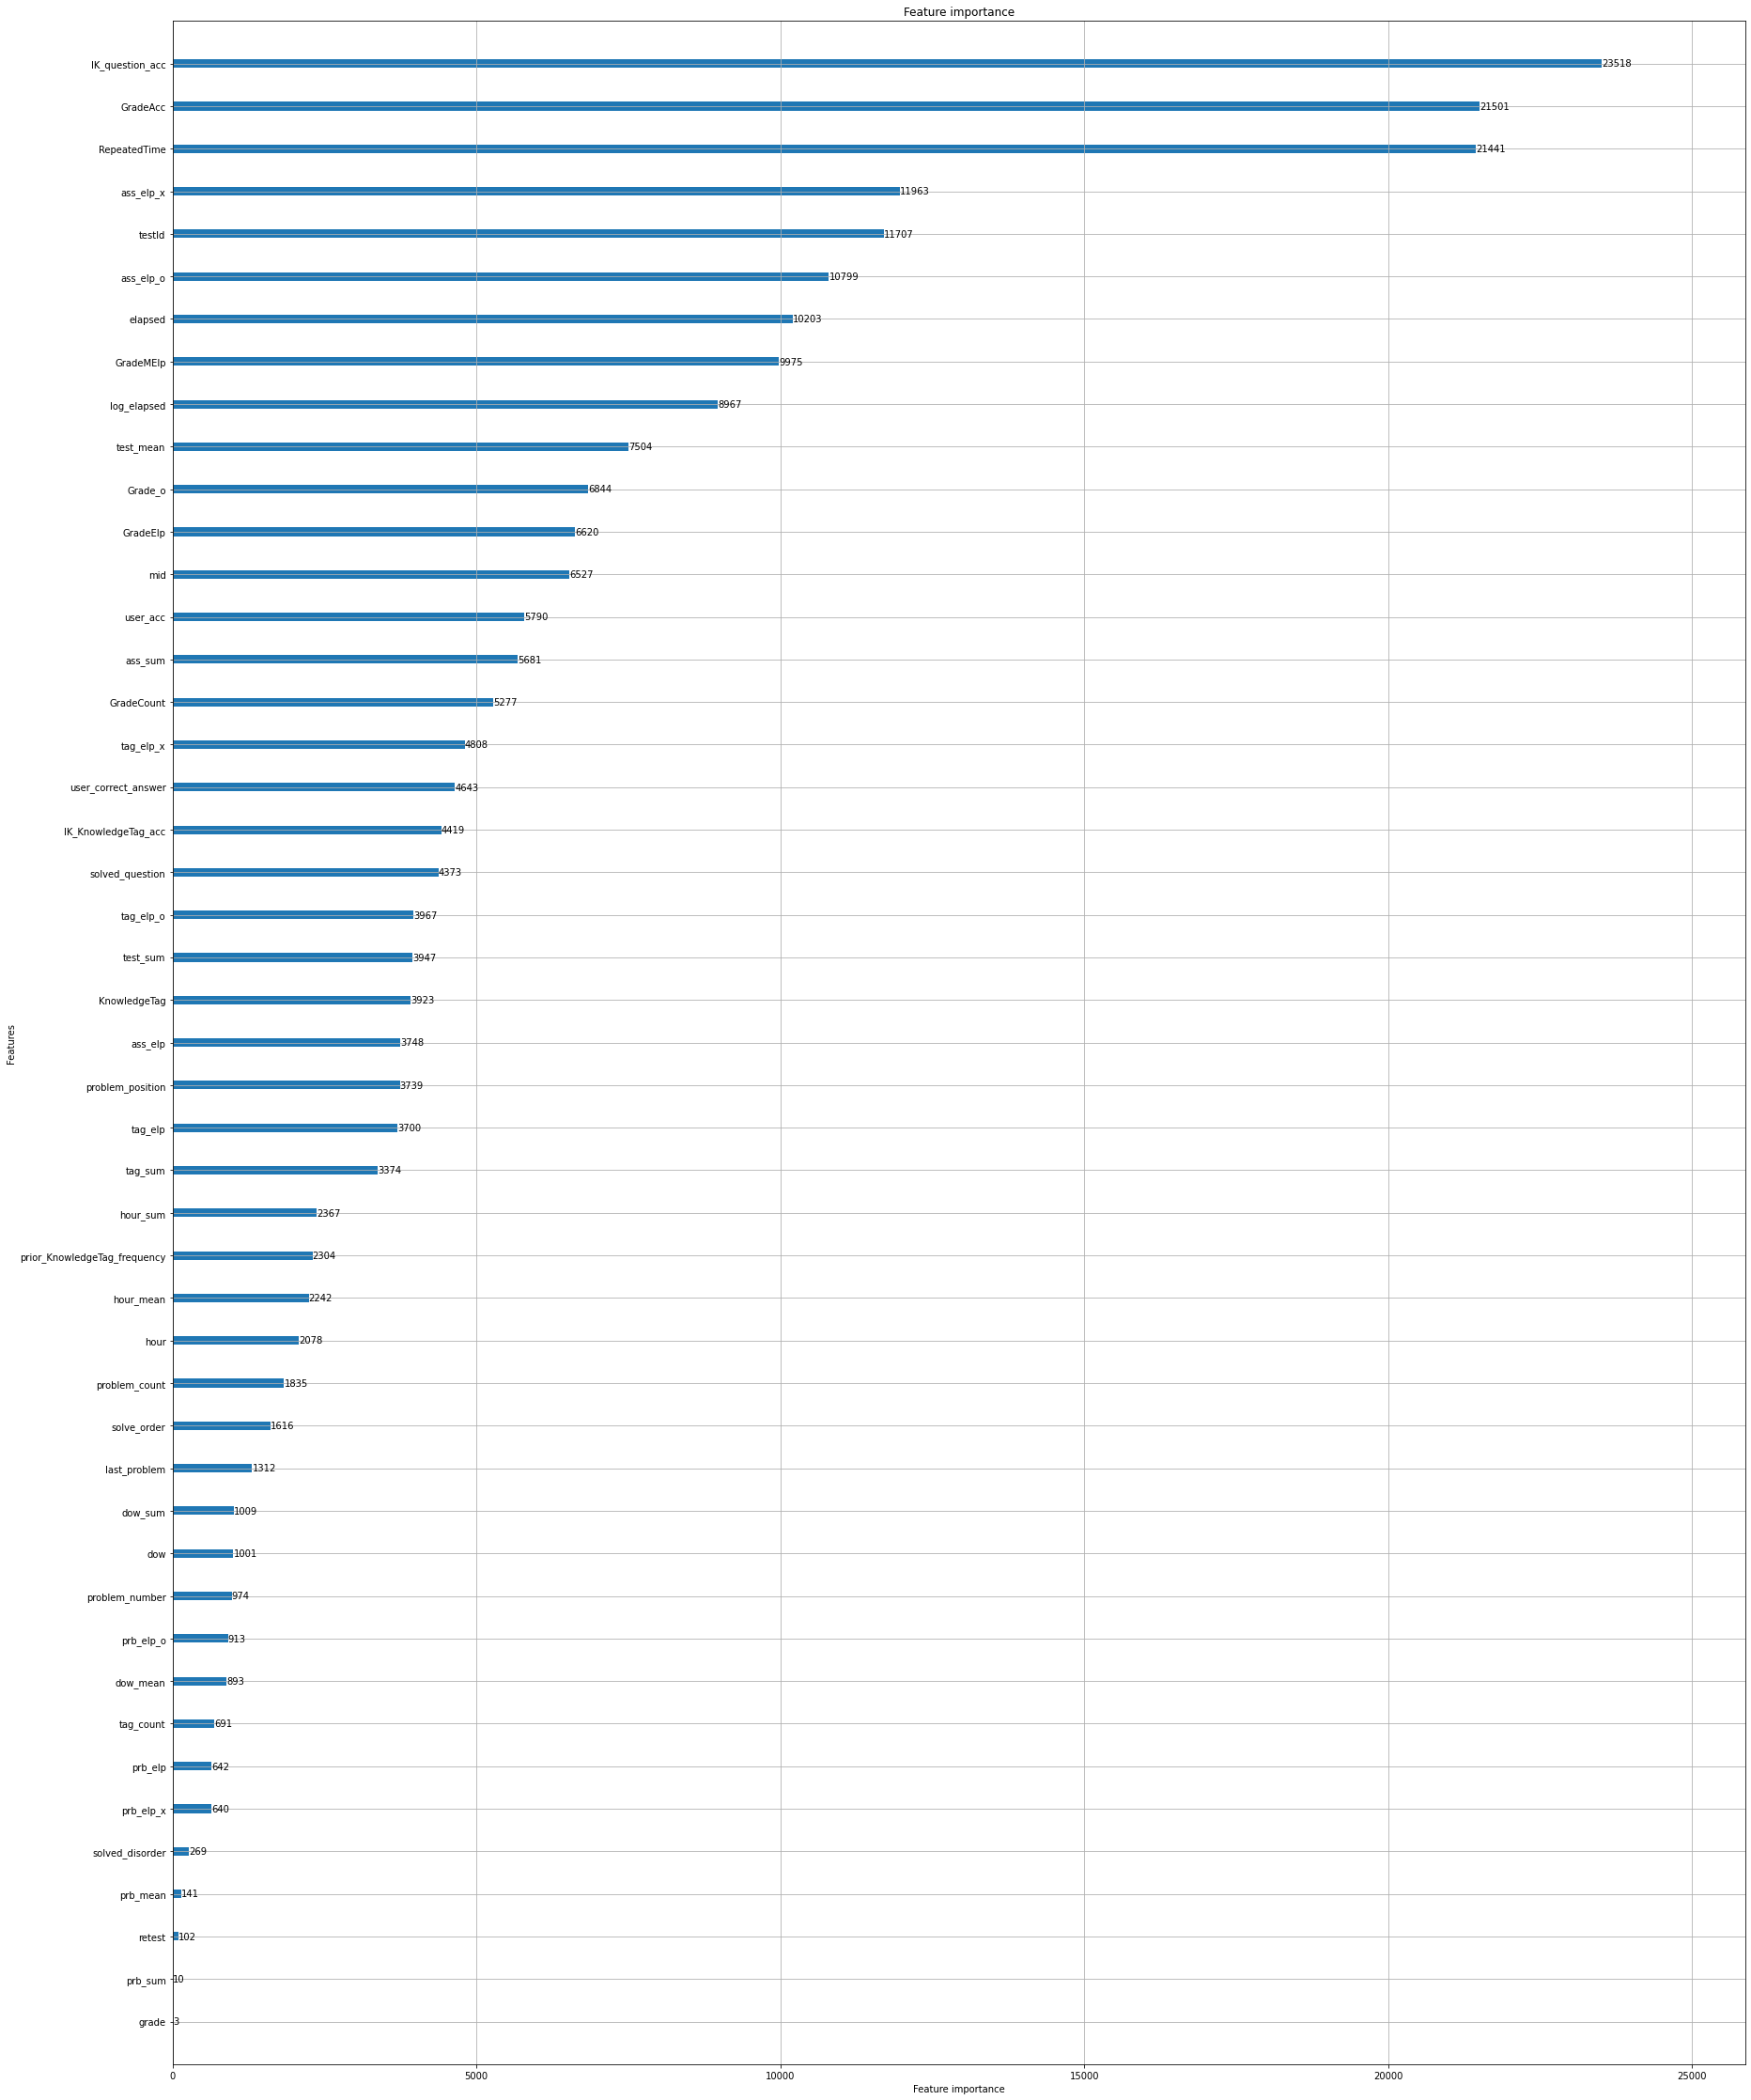

In [34]:
# Feature Importance 파악
import matplotlib.pyplot as plt
ax = lgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(30, 40)

# INFERENCE

In [35]:
# MAKE PREDICTION
total_preds = model.predict(test[FEATS])

In [36]:
# SAVE OUTPUT
output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM4.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM4.csv


In [37]:
len(total_preds)

744